In [27]:
import csv
import matplotlib.pyplot as plt;
import numpy as np
import os
import time
import concurrent
import subprocess
import contextlib
        
DATASET = "yt_bb_detection_validation.csv"
VID_DIR = "./videos/yt_bb_detection_validation"
FNULL = open(os.devnull, 'w')    

In [2]:
# Show some rows
with open(DATASET, "r") as f:
    reader = csv.reader(f)
    i = 0
    
    for row in reader:
        if i == 3:
            break
        print(row)
        i += 1

['AACebVo-JXY', '283000', '3', 'boat', '0', 'absent', '-1.0', '-1.0', '-1.0', '-1.0']
['AACebVo-JXY', '284000', '3', 'boat', '0', 'absent', '-1.0', '-1.0', '-1.0', '-1.0']
['AACebVo-JXY', '285000', '3', 'boat', '0', 'present', '0.065', '0.154', '0.665', '0.69666666']


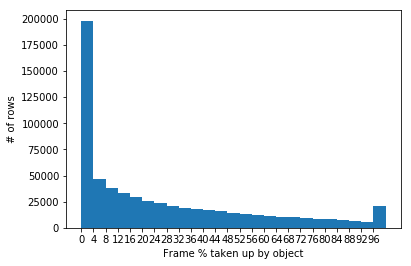

In [3]:
# Plot object size relative to frame
bb_sizes = []

with open(DATASET, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        left, right, top, bottom = map(lambda x: float(x), row[-4:])
        bb_sizes.append((right - left) * (bottom - top) * 100)
plt.hist(bb_sizes, bins=25)
plt.xticks(np.arange(0, 100.0, 100.0/25))
plt.xlabel("Frame % taken up by object")
plt.ylabel("# of rows")
plt.rcParams["figure.figsize"] = (10, 4)
plt.show()

In [19]:
# Entities/utilities for parsing vids/clips
classes = ['person', 'bird', 'bicycle', 'boat', 'bus', 'bear', 'cow', 'cat',
           'giraffe', 'potted plant', 'horse', 'motorcycle', 'knife', 'airplane',
           'skateboard', 'train', 'truck', 'zebra', 'toilet', 'dog', 'elephant',
           'umbrella', 'none', 'car']
class Video(object):
    def __init__(self, yt_id):
        self.yt_id = yt_id
        self.clips = []
        
    def add_clip(self, clip):
        self.clips.append(clip)
        
class Clip(object):
    def __init__(self, yt_id, class_id, object_id):
        self.yt_id = yt_id
        self.class_id = class_id
        self.object_id = object_id
        self.start_ms = None
        self.stop_ms = None
        self.absences = []
        self.box_coords = []
        
    def name(self):
        return '{0}_{1}_{2}'.format(self.yt_id, self.class_id, self.object_id)
    
    def readable_start(self):
        return time.strftime('%H:%M:%S', time.gmtime(self.start_ms/1000.0))
        
    def readable_stop(self):
        return time.strftime('%H:%M:%S', time.gmtime(self.stop_ms/1000.0))    
        
    def add_absence(self, ts_ms):
        self.absences.append(ts_ms)
        
    def add_box_coords(self, coords_tuple):
        self.box_coords.append(coords_tuple)
        
    def __str__(self):
        return '[{0}, {1}, {2}, {3}, {4}]'.format(self.yt_id, self.class_id, 
                                                  self.object_id,
                                                  self.readable_start(),
                                                  self.readable_stop())


def clip_name(clip, yt_id=None, class_id=None, object_id=None):
    if clip is not None:
        return clip.name()
    else:
        return '{0}_{1}_{2}'.format(yt_id, class_id, object_id)
    
def make_new_clip(row):
    clip = Clip(row[0], row[2], row[4])
    clip.start_ms = int(row[1])
    if row[5] == 'absent':
        clip.add_absence(row[1])
    clip.add_box_coords(tuple(row[6:]))
    return clip

In [24]:
# Parse the dataset and get videos, each being a list of clips
videos = []
with open(DATASET, "r") as f:
    reader = csv.reader(f)
    rows = list(reader)
    
    # sort to de-interleave rows since they're initially sorted by youtube-ID, timestamp
    # sort and group together by youtube-ID, class-ID, object-ID, timestamp
    rows.sort(key=lambda row: (row[0], int(row[2]), int(row[4]), int(row[1])))

    curr_yt_id = None
    prev_ts = None
    for row in rows:
        # new video - finish previous video+clip and make a new video+clip
        if row[0] != curr_yt_id:
            if videos:
                videos[-1].clips[-1].stop_ms = int(prev_ts)
                
            curr_yt_id = row[0]
            videos.append(Video(curr_yt_id))
            videos[-1].add_clip(make_new_clip(row))

        # new clip - finish previous clip and make a new clip
        elif clip_name(None, row[0], row[2], row[4]) != clip_name(videos[-1].clips[-1]):
            videos[-1].clips[-1].stop_ms = int(prev_ts)
            videos[-1].add_clip(make_new_clip(row))
            
        # same clip - just add absences and bounding boxes
        else:
            if row[5] == 'absent':
                videos[-1].clips[-1].add_absence(row[1])
            videos[-1].clips[-1].add_box_coords(tuple(row[6:]))
            
        prev_ts = row[1]

In [31]:
# Function to download clips of a video by downloading the entire video, then cutting it
# This is faster for videos which have multiple clips.
def download_all_clips(video):
    video_path = os.path.join(VID_DIR, video.yt_id + '.mp4')
    url = os.path.join('youtu.be/', video.yt_id)
    download_cmd = ['youtube-dl', '-f', 'best[ext=mp4]/best',
                    '-o', video_path, url]
    subprocess.check_call(download_cmd, stdout=FNULL, stderr=subprocess.STDOUT)
    
    # ffmpeg the video
    for clip in video.clips:
        clip_name = '{0}_{1}_{2}.mp4'.format(video.yt_id, clip.class_id, clip.object_id)
        clip_path = os.path.join(VID_DIR, clip_name)
        print('Cutting clip {0}'.format(clip_name))
        cut_cmd = ['ffmpeg', '-i', dest_path, '-ss', clip.readable_start,
                   '-to', clip.readable_stop, '-c', 'copy', clip_path]
        subprocess.check_call(cut_cmd)
        
    with contextlib.suppress(FileNotFoundError):
        os.remove(video_path)
        
# Download all the videos and cut them
os.makedirs(VID_DIR, exist_ok=True)

with concurrent.futures.ProcessPoolExecutor() as executor:
    for video in videos:
        executor.submit(download_all_clips, video)

Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip %s_%s_%s.mp4
Cutting clip

KeyboardInterrupt: 

Cutting clip %s_%s_%s.mp4


In [94]:
# Pick a couple of videos and ffmpeg them.
classes = ["airplane", "bike", "bird", "boat", "bus",
           "car", "cat", "cow", "dog", "horse", "motorcycle",
           "person", "plotted plant", "train"]

# Each class has a set of 100 video segments
# Each segment is a list of rows with the same video-ID, class-ID, object-ID
vids = {clss: [] for clss in classes}
keep_absent = False
num_vids_per_class = 100

def possibly_add_segment(rows):
    # rows is a segment (see above)
    clss = rows[0][3]
    
    if clss not in classes:
        return
    
    if len(vids[clss]) < num_vids_per_class or random.random() < 0.5:
        vids[clss].append(rows)
        return
    
    # remove existing segment
    idx = random.randrange(0, len(vids[clss]))
    vids[clss][idx], vids[clss][-1] = vids[clss][-1], vids[clss][idx]
    vids[clss].pop()
    vids[clss].append(rows)

def process_vid_rows(rows):
    # sort to de-interleave rows since they're initially sorted by youtube-ID, timestamp
    # sort and group together by class-ID, object-ID, timestamp
    rows.sort(key=lambda row: (int(row[2]), int(row[4]), int(row[1])))

    curr = []
    for row in rows:
        if curr and row[2] == curr[0][2] and row[4] == curr[0][4]:
            possibly_add_segment(curr)
            del curr[:]
            
        curr.append(row)

with open("yt_bb_detection_validation.csv", "r") as f:
    reader = csv.reader(f)
    vid_rows = []
    for row in reader:
        if row[5] != 'present' and not keep_absent:
            continue
            
        if vid_rows and row[0] != vid_rows[0][0]:
            process_vid_rows(vid_rows)
            del vid_rows[:]
            
        vid_rows.append(row)